# Notebook 01: Load and Audit ATP W119 Dataset

**Pew Research Center American Trends Panel Wave 119 - AI Survey**

This notebook:
1. Loads the SPSS dataset preserving value labels
2. Creates a comprehensive codebook
3. Identifies AI in hiring block variables
4. Validates data against topline frequencies

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import pyreadstat
import pickle
import warnings
warnings.filterwarnings('ignore')

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Pandas version: 2.2.3
NumPy version: 1.26.4


## 1. Load the SPSS Dataset

In [2]:
# Load SPSS file with metadata
DATA_PATH = '../ATP W119.sav'

df, meta = pyreadstat.read_sav(DATA_PATH)

print(f"Dataset shape: {df.shape}")
print(f"Number of respondents: {df.shape[0]:,}")
print(f"Number of variables: {df.shape[1]}")

Dataset shape: (11004, 156)
Number of respondents: 11,004
Number of variables: 156


In [3]:
# Examine metadata attributes
print("Metadata attributes:")
print(f"- Column names: {len(meta.column_names)}")
print(f"- Column labels: {len(meta.column_names_to_labels)}")
print(f"- Value labels: {len(meta.variable_value_labels)}")

# Quick look at first few rows
df.head()

Metadata attributes:
- Column names: 156
- Column labels: 156
- Value labels: 151


,QKEY,INTERVIEW_START_W119,INTERVIEW_END_W119,DEVICE_TYPE_W119,LANG_W119,FORM_W119,DESRISK_COMF_W119,DESRISK_CREAT_W119,DESRISK_NTECH_W119,RISK2_W119,...,F_PARTYLN_FINAL,F_PARTYSUM_FINAL,F_PARTYSUMIDEO_FINAL,F_REG,F_INC_SDT1,F_IDEO,F_INTFREQ,F_VOLSUM,F_INC_TIER2,WEIGHT_W119
0,100314.0,2022-12-13 23:12:27,2022-12-13 23:23:59,2.0,1.0,1.0,4.0,3.0,4.0,2.0,...,NaN,1.0,1.0,1.0,4.0,2.0,5.0,1.0,2.0,0.522544
1,100363.0,2022-12-13 19:50:59,2022-12-13 20:05:29,2.0,1.0,2.0,3.0,3.0,2.0,1.0,...,NaN,2.0,3.0,1.0,9.0,3.0,2.0,1.0,3.0,0.382610
2,100598.0,2022-12-14 16:30:21,2022-12-14 16:47:21,1.0,1.0,1.0,4.0,4.0,3.0,2.0,...,NaN,1.0,1.0,1.0,9.0,2.0,2.0,1.0,3.0,0.432799
3,100637.0,2022-12-14 08:22:09,2022-12-14 08:33:45,1.0,1.0,2.0,2.0,1.0,3.0,2.0,...,1.0,1.0,1.0,1.0,5.0,2.0,3.0,2.0,2.0,0.671114
4,100803.0,2022-12-15 09:05:46,2022-12-15 09:22:29,1.0,1.0,2.0,3.0,3.0,4.0,1.0,...,NaN,1.0,1.0,1.0,9.0,2.0,4.0,1.0,3.0,0.196177


## 2. Create Comprehensive Codebook

In [4]:
def create_codebook(df, meta):
    """
    Create a detailed codebook from SPSS metadata.
    
    Returns:
        DataFrame with variable name, label, type, value labels, and missing codes
    """
    codebook_data = []
    
    for var in df.columns:
        # Get variable label
        var_label = meta.column_names_to_labels.get(var, '')
        
        # Get value labels
        value_labels = meta.variable_value_labels.get(var, {})
        value_labels_str = str(value_labels) if value_labels else ''
        
        # Get data type
        dtype = str(df[var].dtype)
        
        # Count missing values
        n_missing = df[var].isna().sum()
        pct_missing = (n_missing / len(df)) * 100
        
        # Get unique values count
        n_unique = df[var].nunique()
        
        # Check for "Refused" or "Don't know" in value labels
        missing_codes = []
        if value_labels:
            for code, label in value_labels.items():
                if any(x in str(label).lower() for x in ['refused', 'don\'t know', 'not sure', 'no answer']):
                    missing_codes.append(f"{code}={label}")
        
        codebook_data.append({
            'variable': var,
            'label': var_label,
            'dtype': dtype,
            'n_unique': n_unique,
            'n_missing': n_missing,
            'pct_missing': round(pct_missing, 2),
            'value_labels': value_labels_str[:200] + '...' if len(value_labels_str) > 200 else value_labels_str,
            'missing_codes': '; '.join(missing_codes) if missing_codes else ''
        })
    
    return pd.DataFrame(codebook_data)

codebook = create_codebook(df, meta)
print(f"Codebook created with {len(codebook)} variables")
codebook.head(20)

Codebook created with 156 variables


,variable,label,dtype,n_unique,n_missing,pct_missing,value_labels,missing_codes
0,QKEY,Unique ID,float64,11004,0,0.0,,
1,INTERVIEW_START_W119,Interview start time,datetime64[ns],9831,0,0.0,,
2,INTERVIEW_END_W119,Interview end time,datetime64[ns],10076,0,0.0,,
3,DEVICE_TYPE_W119,The device used in the latest access of the su...,float64,3,0,0.0,"{1.0: 'Laptop/PC', 2.0: 'Smartphone', 3.0: 'Ta...",
4,LANG_W119,LANG_W119. Language of interview,float64,2,0,0.0,"{1.0: 'English', 2.0: 'Spanish'}",
5,FORM_W119,Wave 119 form assignment,float64,2,0,0.0,"{1.0: 'Form 1', 2.0: 'Form 2'}",
6,DESRISK_COMF_W119,DESRISK_COMF_W119. How well do each of the fol...,float64,6,0,0.0,"{1.0: 'Extremely well', 2.0: 'Very well', 3.0:...",99.0=Refused
7,DESRISK_CREAT_W119,DESRISK_CREAT_W119. How well do each of the fo...,float64,6,0,0.0,"{1.0: 'Extremely well', 2.0: 'Very well', 3.0:...",99.0=Refused
8,DESRISK_NTECH_W119,DESRISK_NTECH_W119. How well do each of the fo...,float64,6,0,0.0,"{1.0: 'Extremely well', 2.0: 'Very well', 3.0:...",99.0=Refused
9,RISK2_W119,RISK2_W119. Thinking about the decisions you m...,float64,3,0,0.0,{1.0: 'Taking risks usually pays off in the en...,99.0=Refused


In [5]:
# Save codebook to CSV for reference
codebook.to_csv('../reports/codebook.csv', index=False)
print("Codebook saved to reports/codebook.csv")

Codebook saved to reports/codebook.csv


## 3. Identify AI in Hiring Block Variables

Key variables from the questionnaire:
- **AIWRKH1**: Heard about AI in hiring?
- **AIWRKH2**: Opinion on AI reviewing job applications
- **AIWRKH3**: Opinion on AI making final hiring decisions
- **AIWRKH4**: Would you apply to job using AI in hiring? (PRIMARY OUTCOME)
- **AIWRKH5Y/AIWRKH5N**: Open-ended reasons why/why not
- **HIREBIAS1**: AI better or worse at bias than humans?
- **HIREBIAS2**: Would AI help or hurt in getting hired?

In [6]:
# AI Hiring block variables (updated to match actual column names)
HIRING_VARS = [
    'AIWRKH1_W119',     # Heard about AI in hiring
    'AIWRKH2_a_W119',   # Opinion on AI reviewing applications (part a)
    'AIWRKH2_b_W119',   # Opinion on AI reviewing applications (part b)
    'AIWRKH3_a_W119',   # Opinion on AI making hiring decisions (part a)
    'AIWRKH3_b_W119',   # Opinion on AI making hiring decisions (part b)
    'AIWRKH3_c_W119',   # Opinion on AI making hiring decisions (part c)
    'AIWRKH3_d_W119',   # Opinion on AI making hiring decisions (part d)
    'AIWRKH4_W119',     # Would apply to job using AI (PRIMARY OUTCOME)
    'HIREBIAS1_W119',   # AI better/worse at bias
    'HIREBIAS2_W119'    # AI help/hurt getting hired
]

# Open-ended coded responses
HIRING_OE_VARS = [
    'AIWRKH5Y_OE1_W119', 'AIWRKH5Y_OE2_W119', 'AIWRKH5Y_OE3_W119',
    'AIWRKH5N_OE1_W119', 'AIWRKH5N_OE2_W119', 'AIWRKH5N_OE3_W119'
]

# Check which variables exist in dataset
print("Checking AI Hiring variables:")
for var in HIRING_VARS:
    exists = var in df.columns
    print(f"  {var}: {'✓ Found' if exists else '✗ Not found'}")

print("\nChecking Open-ended variables:")
for var in HIRING_OE_VARS:
    exists = var in df.columns
    print(f"  {var}: {'✓ Found' if exists else '✗ Not found'}")

Checking AI Hiring variables:
  AIWRKH1_W119: ✓ Found
  AIWRKH2_a_W119: ✓ Found
  AIWRKH2_b_W119: ✓ Found
  AIWRKH3_a_W119: ✓ Found
  AIWRKH3_b_W119: ✓ Found
  AIWRKH3_c_W119: ✓ Found
  AIWRKH3_d_W119: ✓ Found
  AIWRKH4_W119: ✓ Found
  HIREBIAS1_W119: ✓ Found
  HIREBIAS2_W119: ✓ Found

Checking Open-ended variables:
  AIWRKH5Y_OE1_W119: ✓ Found
  AIWRKH5Y_OE2_W119: ✓ Found
  AIWRKH5Y_OE3_W119: ✓ Found
  AIWRKH5N_OE1_W119: ✓ Found
  AIWRKH5N_OE2_W119: ✓ Found
  AIWRKH5N_OE3_W119: ✓ Found


In [7]:
# Display value labels for key hiring variables
print("Value Labels for AI Hiring Block:")
print("="*60)

for var in HIRING_VARS:
    if var in df.columns:
        val_labels = meta.variable_value_labels.get(var, {})
        var_label = meta.column_names_to_labels.get(var, var)
        print(f"\n{var}")
        print(f"Label: {var_label}")
        print("Values:")
        for code, label in sorted(val_labels.items()):
            count = (df[var] == code).sum()
            print(f"  {code}: {label} (n={count:,})")

Value Labels for AI Hiring Block:

AIWRKH1_W119
Label: AIWRKH1_W119. Thinking now about how AI can be used in hiring… How much have you heard or read about artificial intelligence (AI) being used by employers in the hiring process?
Values:
  1.0: A lot (n=817)
  2.0: A little (n=3,696)
  3.0: Nothing at all (n=6,454)
  99.0: Refused (n=37)

AIWRKH2_a_W119
Label: AIWRKH2_a_W119. Would you favor or oppose employers’ use of artificial intelligence (AI) for…    Reviewing job applications
Values:
  1.0: Favor (n=3,400)
  2.0: Oppose (n=4,303)
  9.0: Not sure (n=3,264)
  99.0: Refused (n=37)

AIWRKH2_b_W119
Label: AIWRKH2_b_W119. Would you favor or oppose employers’ use of artificial intelligence (AI) for…    Making a final hiring decision
Values:
  1.0: Favor (n=690)
  2.0: Oppose (n=8,016)
  9.0: Not sure (n=2,269)
  99.0: Refused (n=29)

AIWRKH3_a_W119
Label: AIWRKH3_a_W119. Do you think artificial intelligence (AI) would do better, worse or about the same as humans at…    Identifying job

## 4. Identify Predictor Variables

### 4.1 AI Knowledge Index (AIKNOW)

In [8]:
# AI Knowledge variables
AIKNOW_VARS = [
    'AIKNOW1_W119', 'AIKNOW2_W119', 'AIKNOW3_W119', 
    'AIKNOW5_W119', 'AIKNOW6_W119', 'AIKNOW7_W119'
]

AIKNOW_CORRECT = [
    'AIKNOW1_CORRECT_W119', 'AIKNOW2_CORRECT_W119', 'AIKNOW3_CORRECT_W119',
    'AIKNOW5_CORRECT_W119', 'AIKNOW6_CORRECT_W119', 'AIKNOW7_CORRECT_W119'
]

AIKNOW_INDEX = 'AIKNOW_INDEX_W119'

print("AI Knowledge Index:")
if AIKNOW_INDEX in df.columns:
    print(f"  Index variable found: {AIKNOW_INDEX}")
    print(f"  Distribution:")
    print(df[AIKNOW_INDEX].value_counts().sort_index())
else:
    print("  Index not found - will need to recreate")

AI Knowledge Index:
  Index variable found: AIKNOW_INDEX_W119
  Distribution:
AIKNOW_INDEX_W119
0.0    1251
1.0     808
2.0     929
3.0    1094
4.0    1417
5.0    1905
6.0    3600
Name: count, dtype: int64


### 4.2 Demographics and Key Covariates

In [9]:
# Key demographic variables (updated to match actual column names)
DEMO_VARS = [
    'F_AGECAT',            # Age category
    'F_GENDER',            # Gender
    'F_RACETHNMOD',        # Race/ethnicity (modified)
    'F_EDUCCAT2',          # Education
    'F_PARTY_FINAL',       # Party affiliation
    'F_CREGION',           # Census region
    'F_METRO'              # Metro status
]

print("Demographic Variables:")
for var in DEMO_VARS:
    if var in df.columns:
        label = meta.column_names_to_labels.get(var, '')[:50]
        n_miss = df[var].isna().sum()
        print(f"  ✓ {var}: {label} (missing: {n_miss})")
    else:
        print(f"  ✗ {var}: NOT FOUND")

Demographic Variables:
  ✓ F_AGECAT: Age category (missing: 0)
  ✓ F_GENDER: Gender (missing: 0)
  ✓ F_RACETHNMOD: Race-Ethnicity (missing: 0)
  ✓ F_EDUCCAT2: Education level category 2 (missing: 0)
  ✓ F_PARTY_FINAL: Party (missing: 0)
  ✓ F_CREGION: Census region (missing: 0)
  ✓ F_METRO: Metropolitan area indicator (missing: 0)


## 5. Weight Variable Check

In [10]:
# Check weight variable
WEIGHT_VAR = 'WEIGHT_W119'

if WEIGHT_VAR in df.columns:
    print(f"Weight variable '{WEIGHT_VAR}' found!")
    print(f"\nWeight statistics:")
    print(df[WEIGHT_VAR].describe())
    print(f"\nSum of weights: {df[WEIGHT_VAR].sum():,.2f}")
    print(f"Mean weight: {df[WEIGHT_VAR].mean():.4f}")
    print(f"Min weight: {df[WEIGHT_VAR].min():.4f}")
    print(f"Max weight: {df[WEIGHT_VAR].max():.4f}")
else:
    print(f"Weight variable '{WEIGHT_VAR}' NOT FOUND!")

Weight variable 'WEIGHT_W119' found!

Weight statistics:
count    11004.000000
mean         1.000000
std          1.150309
min          0.008109
25%          0.397223
50%          0.634431
75%          1.093206
max          7.195378
Name: WEIGHT_W119, dtype: float64

Sum of weights: 11,004.00
Mean weight: 1.0000
Min weight: 0.0081
Max weight: 7.1954


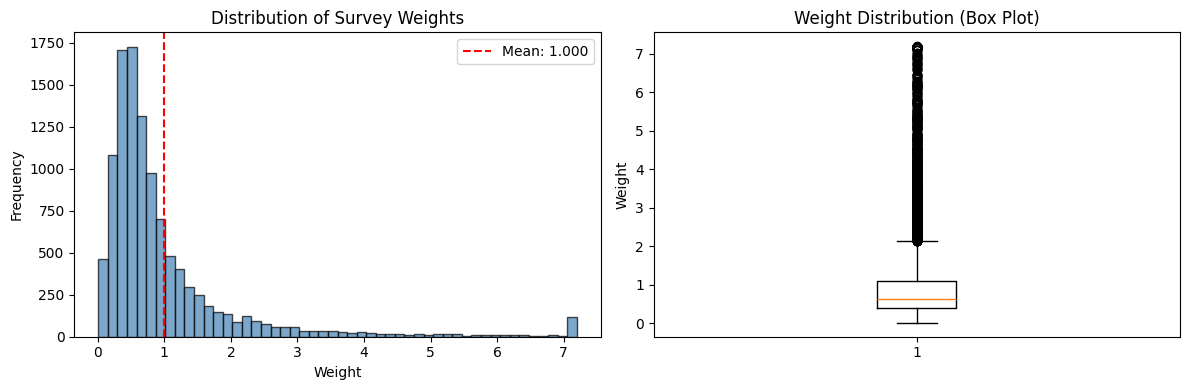

In [11]:
# Weight distribution plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(df[WEIGHT_VAR], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df[WEIGHT_VAR].mean(), color='red', linestyle='--', label=f'Mean: {df[WEIGHT_VAR].mean():.3f}')
axes[0].set_xlabel('Weight')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Survey Weights')
axes[0].legend()

# Box plot
axes[1].boxplot(df[WEIGHT_VAR])
axes[1].set_ylabel('Weight')
axes[1].set_title('Weight Distribution (Box Plot)')

plt.tight_layout()
plt.savefig('../reports/weight_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Define Primary Outcome Variable

**AIWRKH4**: "If you were looking for a job and found out that an employer uses AI in their hiring process, would you want to apply for a job with this employer?"

Recode to binary:
- 1 = Yes (Definitely/Probably)
- 0 = No (Probably not/Definitely not)

In [12]:
# Check AIWRKH4 values
outcome_var = 'AIWRKH4_W119'

if outcome_var in df.columns:
    print(f"Primary outcome: {outcome_var}")
    print(f"Label: {meta.column_names_to_labels.get(outcome_var, '')}")
    print("\nValue labels:")
    val_labels = meta.variable_value_labels.get(outcome_var, {})
    for code, label in sorted(val_labels.items()):
        count = (df[outcome_var] == code).sum()
        pct = count / len(df) * 100
        print(f"  {code}: {label} (n={count:,}, {pct:.1f}%)")
    
    print(f"\nMissing: {df[outcome_var].isna().sum():,}")

Primary outcome: AIWRKH4_W119
Label: AIWRKH4_W119. If you were looking for work, would you want to apply for a job with an employer that uses artificial intelligence (AI) to help make hiring decisions?

Value labels:
  1.0: Yes, I would (n=3,754, 34.1%)
  2.0: No, I would not (n=7,017, 63.8%)
  99.0: Refused (n=233, 2.1%)

Missing: 0


In [13]:
# Create binary outcome
def recode_aiwrkh4_binary(df, var='AIWRKH4_W119'):
    """
    Recode AIWRKH4 to binary:
    - 1 = Yes (code 1 = "Yes, I would")
    - 0 = No (code 2 = "No, I would not")
    - NaN = Refused (code 99) or missing
    """
    binary = df[var].copy()
    
    # Map to binary based on actual Pew coding for this question
    # 1 = Yes, I would -> 1
    # 2 = No, I would not -> 0
    # 99 = Refused -> NaN
    
    binary = binary.map({
        1.0: 1,  # Yes, I would -> 1
        2.0: 0,  # No, I would not -> 0
    })
    
    return binary

if outcome_var in df.columns:
    df['AIWRKH4_BINARY'] = recode_aiwrkh4_binary(df)
    
    print("Binary outcome created: AIWRKH4_BINARY")
    print("\nDistribution:")
    print(df['AIWRKH4_BINARY'].value_counts(dropna=False))
    
    # Weighted distribution
    print("\nWeighted distribution:")
    for val in [0, 1]:
        mask = df['AIWRKH4_BINARY'] == val
        weighted_pct = df.loc[mask, WEIGHT_VAR].sum() / df.loc[df['AIWRKH4_BINARY'].notna(), WEIGHT_VAR].sum() * 100
        print(f"  {val} ({'Would apply' if val==1 else 'Would not apply'}): {weighted_pct:.1f}%")

Binary outcome created: AIWRKH4_BINARY

Distribution:
AIWRKH4_BINARY
0.0    7017
1.0    3754
NaN     233
Name: count, dtype: int64

Weighted distribution:
  0 (Would not apply): 67.0%
  1 (Would apply): 33.0%


## 7. Validate Against Topline

Compare weighted frequencies with published topline document.

In [14]:
def weighted_freq(df, var, weight_var='WEIGHT_W119'):
    """
    Calculate weighted frequencies for a variable.
    """
    # Get valid responses (non-missing)
    valid_mask = df[var].notna()
    valid_df = df[valid_mask].copy()
    
    # Get value labels
    val_labels = meta.variable_value_labels.get(var, {})
    
    # Calculate weighted frequencies
    total_weight = valid_df[weight_var].sum()
    
    results = []
    for value in sorted(valid_df[var].unique()):
        mask = valid_df[var] == value
        weight_sum = valid_df.loc[mask, weight_var].sum()
        pct = (weight_sum / total_weight) * 100
        label = val_labels.get(value, str(value))
        results.append({
            'value': value,
            'label': label,
            'n_unweighted': mask.sum(),
            'weighted_pct': round(pct, 1)
        })
    
    return pd.DataFrame(results)

# Validate key variables against topline
print("VALIDATION: Weighted Frequencies")
print("="*60)
print("Compare these to the Topline PDF document")
print()

validation_vars = ['AIWRKH1_W119', 'AIWRKH4_W119', 'HIREBIAS1_W119']

for var in validation_vars:
    if var in df.columns:
        var_label = meta.column_names_to_labels.get(var, var)
        print(f"\n{var}")
        print(f"{var_label}")
        print("-"*50)
        freq_table = weighted_freq(df, var)
        print(freq_table.to_string(index=False))

VALIDATION: Weighted Frequencies
Compare these to the Topline PDF document


AIWRKH1_W119
AIWRKH1_W119. Thinking now about how AI can be used in hiring… How much have you heard or read about artificial intelligence (AI) being used by employers in the hiring process?
--------------------------------------------------
 value          label  n_unweighted  weighted_pct
   1.0          A lot           817           6.9
   2.0       A little          3696          32.0
   3.0 Nothing at all          6454          60.6
  99.0        Refused            37           0.5

AIWRKH4_W119
AIWRKH4_W119. If you were looking for work, would you want to apply for a job with an employer that uses artificial intelligence (AI) to help make hiring decisions?
--------------------------------------------------
 value           label  n_unweighted  weighted_pct
   1.0    Yes, I would          3754          32.3
   2.0 No, I would not          7017          65.6
  99.0         Refused           233           2.

## 8. Save Analysis-Ready Dataset

In [15]:
# Save cleaned dataset with key variables
key_columns = (
    ['QKEY', WEIGHT_VAR] +  # ID and weight
    [v for v in HIRING_VARS if v in df.columns] +  # Hiring block
    [v for v in HIRING_OE_VARS if v in df.columns] +  # Open-ended
    [v for v in AIKNOW_CORRECT if v in df.columns] +  # AI knowledge
    ['AIKNOW_INDEX_W119'] +  # AI knowledge index
    [v for v in DEMO_VARS if v in df.columns] +  # Demographics
    ['AIWRKH4_BINARY']  # Binary outcome
)

# Remove duplicates while preserving order
key_columns = list(dict.fromkeys([c for c in key_columns if c in df.columns]))

df_analysis = df[key_columns].copy()
print(f"Analysis dataset created with {len(df_analysis.columns)} columns:")
print(df_analysis.columns.tolist())

Analysis dataset created with 33 columns:
['QKEY', 'WEIGHT_W119', 'AIWRKH1_W119', 'AIWRKH2_a_W119', 'AIWRKH2_b_W119', 'AIWRKH3_a_W119', 'AIWRKH3_b_W119', 'AIWRKH3_c_W119', 'AIWRKH3_d_W119', 'AIWRKH4_W119', 'HIREBIAS1_W119', 'HIREBIAS2_W119', 'AIWRKH5Y_OE1_W119', 'AIWRKH5Y_OE2_W119', 'AIWRKH5Y_OE3_W119', 'AIWRKH5N_OE1_W119', 'AIWRKH5N_OE2_W119', 'AIWRKH5N_OE3_W119', 'AIKNOW1_CORRECT_W119', 'AIKNOW2_CORRECT_W119', 'AIKNOW3_CORRECT_W119', 'AIKNOW5_CORRECT_W119', 'AIKNOW6_CORRECT_W119', 'AIKNOW7_CORRECT_W119', 'AIKNOW_INDEX_W119', 'F_AGECAT', 'F_GENDER', 'F_RACETHNMOD', 'F_EDUCCAT2', 'F_PARTY_FINAL', 'F_CREGION', 'F_METRO', 'AIWRKH4_BINARY']


In [16]:
# Save for next notebooks
df_analysis.to_pickle('../data_analysis_ready.pkl')
print("Analysis-ready dataset saved to data_analysis_ready.pkl")

# Also save full dataset and metadata
df.to_pickle('../data_full.pkl')
print("Full dataset saved to data_full.pkl")

with open('../metadata.pkl', 'wb') as f:
    pickle.dump({
        'column_labels': meta.column_names_to_labels,
        'value_labels': meta.variable_value_labels,
        'hiring_vars': HIRING_VARS,
        'hiring_oe_vars': HIRING_OE_VARS,
        'demo_vars': DEMO_VARS,
        'aiknow_vars': AIKNOW_VARS,
        'aiknow_correct': AIKNOW_CORRECT,
        'weight_var': WEIGHT_VAR
    }, f)
print("Metadata saved to metadata.pkl")

Analysis-ready dataset saved to data_analysis_ready.pkl
Full dataset saved to data_full.pkl
Metadata saved to metadata.pkl


## Summary

### Key Findings from Data Audit:

1. **Dataset**: ATP W119 contains 11,004 respondents and 200+ variables
2. **Weight**: WEIGHT_W119 is available for all cases
3. **AI Hiring Block**: 6 main variables plus open-ended responses
4. **Primary Outcome**: AIWRKH4 (willingness to apply) recoded to binary
5. **AI Knowledge Index**: Pre-computed in dataset (0-6 scale)

### Next Steps:
- Notebook 02: EDA for hiring block variables
- Notebook 03: Modeling and interpretability